In [1]:
# TODO essaye de change le skill en dictionnaire et OneHotEncoder au lieu de Get_dummy

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
jobs = ['Data scientist', 'Python', 'Javascript', 'Java','Data scientist', 'Python', 'Javascript', 'Java']
countrys = ['France','France','France','France', 'USA','USA','USA','USA']

# prendres tout les noms de fichiers csv dans le array
filenames = [str.lower(job).replace(' ','')+str.lower(country)+'.csv' for job, country in zip(jobs,countrys) ]

dfs = [pd.read_csv(filename, sep=';', encoding="utf-8-sig") for filename in filenames]

# Ajouter une colonne indique le métier
dfs[0]['Métier'] = 'Data Scientist' 
dfs[1]['Métier'] = 'Développeur Python'
dfs[2]['Métier'] = 'Développeur JavaScript'
dfs[3]['Métier'] = 'Développeur Java'
dfs[4]['Métier'] = 'Data Scientist'
dfs[5]['Métier'] = 'Développeur Python'
dfs[6]['Métier'] = 'Développeur JavaScript'
dfs[7]['Métier'] = 'Développeur Java'

# Créer le dataframe à partir de la concaténations de ces fichiers
df = pd.concat(dfs)
df = df[df.Description.isna()==False]

In [3]:
datascientist = df[(df['Poste'].str.lower().str.contains('data')) & (df['Poste'].str.lower().str.contains('scientist'))]
df = pd.concat([df[df['Métier'] != 'Data Scientist'], datascientist], ignore_index=True)

In [4]:
# Les mots clés des compétences
skills = ['Python', 'langage R', 'SQL', 'NoSQL', 'GIT', 'Spark', 'Flask', 'Streamlit', 'Docker', 'Kubernetes', 'React', 'Machine-Learning', 'Deep Learning', 'NLP', 'Vue', 'Angular', 'Scala', 'PySpark','PowerBI', 'SQLServer', 'Dataiku','Data', 'Keras', 'Tensor-Flow', 'NLU', 'PyTorch', 'Scikit-Learn', 'SAAS', 'Java', 'Scikit learn', 'Hadoop', 'Hive', 'ML','DL', 'Azure', 'AWS']


# skills2 = {'Python':['Python', 'python', 'R', 'langage R', 'Langage R']
# }
# contrats = ['CDI','CDD','Apprentissage','Contrat pro','Stage','Intérim','Freelance','Indépendant','Freelance']

# Les mots clés des niveaux d'études
studylevel_keywords = {'High School':['High School','Baccalauréat'],
                       'Guaduate': ['Université','Universitaire','Formation supérieure','Guaduate','Bac +2','Bac +3','Bachelor'],
                       'Master': ['Master','Master 2', 'Master +2', 'Bac +5', 'Bac+5', 'Bac +4','Bac+4','Grande école d\'ingénieur','Bac +4/5','M2','Cursus ingénieur', 'engineer','Diplôme ingénieur'],
                       'Doctor': ['Doctorat', 'Doctor'], 
                       'Formation': ['Formation Data Science']
                       }

# Les mots clés des niveaux d'expériences
explevel_keywords = {'Beginer':['Débutant', 'Beginer','No experience','Apprenant','Stage','Stagiaire','Pas d`\'expérience', '1 an', '0-1 an','0 - 1 an', '0/1 an','0 / 1 an'],
                       'Intermediate': ['Intermédiaire','Intermediate','2 year', '3 year','2-3 year',  '2 ans', '2/3 an', '1-2 an','1-3  years'],
                       'Confirmed': ['Confirmé','Confirmed','3 an','4 an','5 an','3 year','4 year','5 year','3-5 year','3-5 an','3/5 year', '3/5 an'],
                       'Expert': ['Expert','6 year','7 year', '8 year', '9 year','6 an','7 an', '8 an','9 an','10 an','5-10 year','5-10 an','5 - 10 an','5/10 year', '5/10 an'],
                       'Senior': ['Senior', '10+ years', '10+ an', '10 ans +','plus de 10 an']
                       }

# Regex pour récupérer les chaînes pour indique les salaires
salaryMatch = re.compile(r'((([\$€]\s?\d+([\.,\s]?\d{3})*[\s]?k?([\.,\s]\d{2})?([\s]?((à)|(au)|(et)|(\/)|(->?)|(to)|(and))?[\s]?[\$€]?[\s]?\d{1,3}([\.,\s]?\d{3})*\s?k?([\.,\s]?\d{2})?)?)|((\d+([\.,\s]?\d{3})*\s?k?([\.,\s]\d{2})?\s?[\$€]?([\s]?((à)|(au)|(et)|(and)|(\/)|(->?)|(to))?[\s]?\d{1,3}([\.,\s]?\d{3})*\s?k?([\.,\s]\d{2})?)?)[€\$])[\s]?)(\s*(brut)?\s*((par)|(a)|(an)|(per)|(by)|(\/)|(every)|(un)|(une))[\s]*((annually)|(heure)|(jour)|(hebdomadaire)|(mois)|(mensuel)|(hour)|(day)|(month)|(year)|(an))))')

In [5]:
# La fonction vérifie si un terme existe dans une chaîne de caractère
def exist_in_array(x, dicto):

    for key in dicto:
        if any(str.lower(term) in str.lower(x) for term in dicto[key]):
            return key
        else:
            pass
    return None

# La fonction vérifie si dans la colonne ['Description'] de chaque ligne, s'il trouve descompétences dans le dictionnaire, si oui, il met un 1
def skill_required(row, skills):

    desc_low = str.lower(row['Description'])
    
    for skill in skills:

        skill_low = str.lower(skill)

        if (skill_low in desc_low) or (skill_low.replace(' ','') in desc_low) or (skill_low.replace('-','') in desc_low)  or (skill_low.replace('-',' ') in desc_low):
            row[skill] = 1

    return row

# La fonction retourne le résultat obtenu à partir d'un string et regex
def searchBy(x,pattern):
    match = re.search(pattern,str.lower(x))
    if match:
        return match.group(0)

# Fonction qui retourne un numbre de format correcte à partir des nombres en format de string
def correct_number(string):
    numb_string = str(string).replace(' ','').replace('k','000')

   # Si le nombre a un virgule devant les deux dernier chiffres 
    if re.match('^.+[.]\d{2}$',numb_string):
        numb = numb_string.replace(',','')
        return(float(numb))
        
   # Si le nombre a un point devant les deux dernier chiffres
    elif re.match('^.+[,]\d{2}$',numb_string):
        numb = numb_string.replace(',','.')
        return(float(numb))
    
   # Si le nombre n'a pas de point ni virgule devant les deux dernier chiffres
    else:
        numb = numb_string.replace(',','').replace('\.','')
        return(float(numb))

# fonction qui sépare les salaire minimum et salaire maximum en 2 colonnes différents
def minmaxSalary(row):
    match = re.match(r'(?:\D*)(?:[\$€]?\s?)((?:\d+)(?:[\.,\s]?\d{3})*(?:[\s]?k)?(?:[\.,\s]\d{2})?)(?:[\s]?[\$€]?[\s]?(?:à|au|et|\/|->?|to|and)?[\s]?[\$€]?\s?)((?:\d+)(?:[\.,\s]?\d{3})*(?:[\s]?k)?(?:[\.,\s]\d{2})?)?',row['Salaire'])

    # Si on obtient les salaire minimum et salaire maximum
    if (len(match.groups(0))==2) and (match.groups(0)[1] != 0):

        minSalary = correct_number(match.groups(0)[0])
        maxSalary = correct_number(match.groups(0)[1])

    # Si on obtient juste un salaire
    elif match.groups(0)[1] == 0:

        minSalary = correct_number(match.groups(0)[0])
        maxSalary = minSalary

    # Non retrouvé
    else:

        minSalary = np.nan
        maxSalary = np.nan

    #Si dans le salaire est indiqué le salaire par an
    if re.search(r'(annually)|(year)|(((par)|(per)|(by)|(\/)|(every)|(un)|(une))[\s]?an)',row['Salaire']):
        row['Salaire minimum par an'] = minSalary
        row['Salaire maximum par an'] = maxSalary

    #Si dans le salaire est indiqué le salaire par mois
    elif re.search(r'(month)|(mensuel)|(mois)',row['Salaire']):
        row['Salaire minimum par an'] = minSalary * 12
        row['Salaire maximum par an'] = maxSalary * 12

    #Si dans le salaire est indiqué le salaire par semaine
    elif re.search(r'(week)|(semaine)|(hebdomadaire)',row['Salaire']):
        row['Salaire minimum par an'] = minSalary *4 * 12
        row['Salaire maximum par an'] = maxSalary *4 * 12
    
    #Si dans le salaire est indiqué le salaire par jour
    elif re.search(r'(day)|(jour)',row['Salaire']):
        row['Salaire minimum par an'] = minSalary *22 * 12
        row['Salaire maximum par an'] = maxSalary *22 * 12
    
    #Si dans le salaire est indiqué le salaire par heure
    elif re.search(r'(hour)|(heur)',row['Salaire']):
        row['Salaire minimum par an'] = minSalary *8 * 22  * 12
        row['Salaire maximum par an'] = maxSalary * 8 * 22  * 12
        
    #pour tout autres cas return np.nan
    else:
        row['Salaire minimum par an'] = np.nan
        row['Salaire maximum par an'] = np.nan
    return row
         


# La fonction qui donne un array de quantile à partir de ['Salaire minimum par an'] et ['Salaire maximum par an']
def separe_quantile(df, number):
    list_prob = [ 1/number*i for i in range(1,number+1) ]
    array_min = df['Salaire minimum par an'].quantile(q=list_prob,interpolation="linear")
    array_max = df['Salaire maximum par an'].quantile(q=list_prob,interpolation="linear")
    
    liste_classe = [0]

    for i in range(number):
        liste_classe.append((array_min.values[i] + array_max.values[i])/2)

    liste_classe.pop()
    liste_classe.append(array_max.values[-1])
    return (liste_classe)


    # La fonction qui mets la classe de salaire de chaque ligne
def put_class_salaire(row,classes):
    mean = (row['Salaire minimum par an'] + row['Salaire maximum par an'])/2
    for i in range(len(classes)-1):
        if (classes[i] <= mean) and (mean <= classes[i+1]):
            row['Classe de salaire par an'] = str(int(classes[i]))+(' - ')+str(int(classes[i+1]))
    return row

# La fonction qui prend la colonne ['Ville'] en réduisant la taille pour devenir la colonne ['City']
def extract_city(x):
    regex =re.compile(r'(?:\D*)(?:\()(\d{2})(?:\))|(?:.*)([A-Z]{2})(?:.*)|(?:)')
    resultat = re.match(regex, str(x)).groups(0)
    if(resultat[0]!=0):
        if (int(resultat[0]) == 75) or (int(resultat[0])>90 and int(resultat[0])<=95):
            return "ILE DE FRANCE"
        else:
            return  "AUTRE VILLEFR"
    elif(resultat[1]!=0):
        return resultat[1]
    else:
        pass

In [6]:
# Extraire des niveaux d'étude requis à partir de la colonne ['Description']
df['Study required'] = df['Description'].apply(lambda x: exist_in_array(x, studylevel_keywords))

# Extraire des niveaux d'expérience requis à partir de la colonne ['Description']
df['Experience required'] = df['Description'].apply(lambda x: exist_in_array(x, explevel_keywords))
# Ajouter les colonnes de compétence et extraire la valeur à partir de la colonne ['Description']
df = pd.concat([df, pd.DataFrame(columns=skills)])
df = df.apply(lambda row: skill_required(row, skills), axis=1)

In [7]:
# Extraire des salaires à partir de la colonne  ['Description']
df['SalaryExtract'] = df['Description'].apply(lambda x: searchBy(x ,salaryMatch))

# Remplacer la colonne ['Salaire'] nulle par ['SalaryExtract'], si ['SalaryExtract'] est non nulle aussi
df['Salaire'].update(df['SalaryExtract'])

In [8]:
# Supprimer les lignes dont le salaire n'ont pas de valeur
df = df[df['Salaire'].isna() == False]

In [9]:
# Supprimela colonne ['Type de contrat']  dont on n'a pas besoin
try:    
    df.drop('Contrat', axis=1, inplace=True)
except:
    pass


# Supprimela colonne ['SalaryExtract']  dont on n'a plus besoin
try:
    df.drop('SalaryExtract', axis=1, inplace=True)
except:
    pass

# Supprimer les lignes doublants
df = df.drop_duplicates()

In [10]:
#Ajouter les colonnes ['Salaire minimum par an'] et ['Salaire maximum par an']
df = pd.concat([df, pd.DataFrame(columns=['Salaire minimum par an','Salaire maximum par an'])])


# Assigner les colonnes ['Salaire minimum par an'] et ['Salaire maximum par an'] par les valeurs de la colonne ['Salaire']
df = df.apply(lambda row: minmaxSalary(row), axis=1)



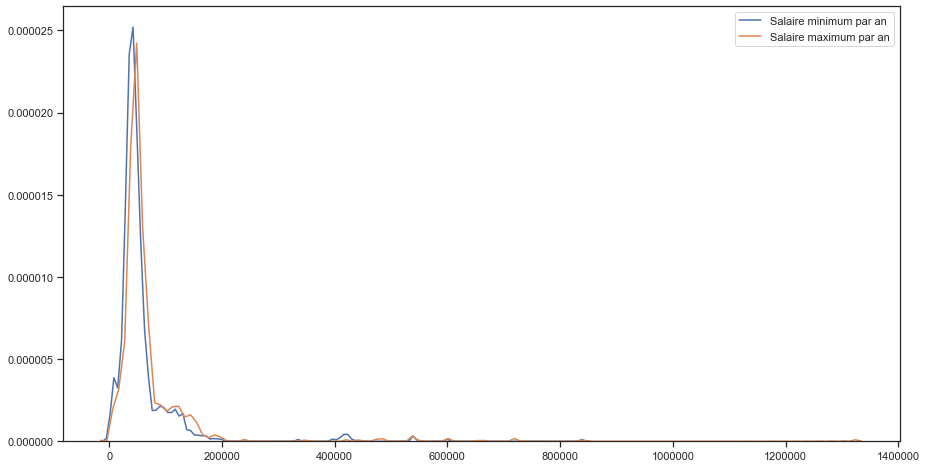

In [11]:
# Prend que des lignes dont la salaires est superireur à un certain numbre 
# df = df[df['Salaire minimum par an']>10000]

# df2 = df.sort_values('Salaire minimum par an')
import seaborn as sns

fig= plt.figure(figsize=(15,8))
# Make default density plot
p1 = sns.kdeplot(df['Salaire minimum par an'])
p2 = sns.kdeplot(df['Salaire maximum par an'])
#sns.plt.show()

In [12]:
min_salaire = pd.DataFrame(df['Salaire minimum par an'].value_counts().sort_index()/len(df))
max_salaire = pd.DataFrame(df['Salaire maximum par an'].value_counts().sort_index()/len(df))

proba_accru_min  = [min_salaire.iloc[0][0]]
proba_accru_max  = [max_salaire.iloc[0][0]]



In [13]:
for i in range(1,min_salaire.shape[0]):
    proba_accru_min.append(proba_accru_min[-1] + min_salaire.iloc[i][0])
for j in range(1,max_salaire.shape[0]):
    proba_accru_max.append(proba_accru_max[-1] + max_salaire.iloc[j][0])

No handles with labels found to put in legend.


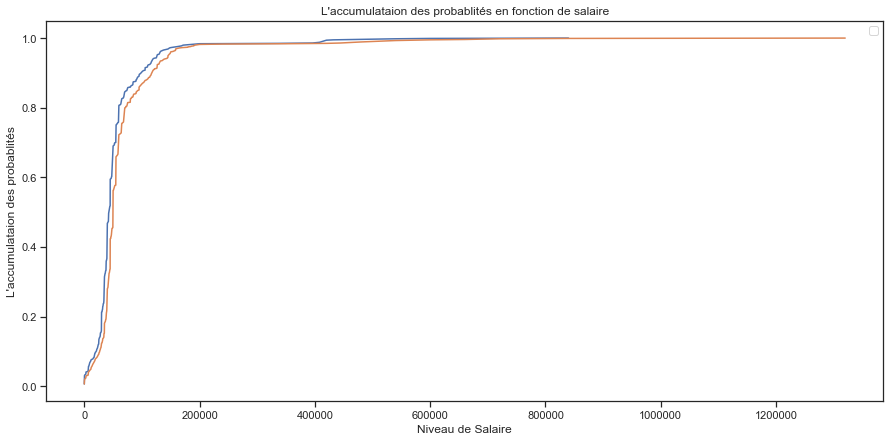

In [14]:
fig= plt.figure(figsize=(15,7))

p1 = plt.plot(min_salaire.index, proba_accru_min)
p2 = plt.plot(max_salaire.index, proba_accru_max)

plt.title('L\'accumulataion des probablités en fonction de salaire')
plt.xlabel('Niveau de Salaire')
plt.ylabel('L\'accumulataion des probablités')
plt.legend()
plt.show()

In [15]:
df['Classe de salaire par an'] = np.nan
df = df.apply(lambda row: put_class_salaire(row, separe_quantile(df,5)), axis=1)

try:
    df = df.drop(['Salaire','Salaire minimum par an', 'Salaire maximum par an', 'Entreprise', 'Description'], axis=1)
except:
    pass

In [16]:
# mappings = []

# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()

# label_df = df.drop('Classe de salaire par an', axis=1)
# for i, col in enumerate(label_df):
#     if label_df[col].dtype == 'object':
#         label_df[col] = label_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
#         mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

data = pd.get_dummies(df,prefix=['Profession','Pays','Experience','Level'], columns = ['Métier','Pays','Experience required','Study required'])

In [17]:
try:
    data.drop(['Description', 'Entreprise'], axis=1, inplace=True)
except:
    pass

try:
    data.drop('Poste', axis=1, inplace=True)
except:
    pass

data.reset_index(drop=True, inplace=True)

data['City'] = data['Ville'].apply(lambda x: extract_city(x))

data = pd.get_dummies(data,prefix=['City'], columns = ['City'])
try:
    data.drop(['Ville'], axis=1, inplace=True)
except:
    pass

data = data.fillna(0)

In [18]:
data

,Python,langage R,SQL,NoSQL,GIT,Spark,Flask,Streamlit,Docker,Kubernetes,...,City_OR,City_PA,City_SC,City_SD,City_TN,City_TX,City_UT,City_VA,City_WA,City_WI
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
983,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
984,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X = data.drop('Classe de salaire par an',axis=1)
y = data['Classe de salaire par an']

# ax = sns.heatmap(data.corr())
X_train, X_test,y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

models = [RandomForestClassifier(n_estimators=100),DecisionTreeClassifier(),LogisticRegression(), SVC(), KNeighborsClassifier(5), GaussianNB(), MultinomialNB(), BernoulliNB()]
models_name = ["RandomForestClassifier","DecisionTreeClassifier","LogisticRegression", "SVC", "KNeighborsClassifier", "GaussianNB", "MultinomialNB", "BernoulliNB"]
#model = LinearRegression()

# Calcule tout les scores en parcourant de bout à bout 
# d_cross =  cross_validate(model, X_train, Y_train)

In [20]:
for i in range(len(models)):
    models[i].fit(X_train, y_train)
    y_pred = models[i].predict(X_test)
    scores =  cross_val_score(models[i], X_train, y_train)
    accuracy = accuracy_score(y_test,y_pred)

    print("Model: ",models_name[i])
    print('Cross mean score: ',scores.mean())
    print('Accuracy: ', accuracy)
    print()

Model:  RandomForestClassifier
Cross mean score:  0.43974844795613965
Accuracy:  0.4898989898989899

Model:  DecisionTreeClassifier
Cross mean score:  0.38783358864790773
Accuracy:  0.4292929292929293



C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

Model:  LogisticRegression
Cross mean score:  0.39033298395549465
Accuracy:  0.4090909090909091

Model:  SVC
Cross mean score:  0.44358622913811174
Accuracy:  0.4494949494949495

Model:  KNeighborsClassifier
Cross mean score:  0.3879142143029912
Accuracy:  0.3383838383838384

Model:  GaussianNB
Cross mean score:  0.2610819962912198
Accuracy:  0.21212121212121213

Model:  MultinomialNB
Cross mean score:  0.396702410707087
Accuracy:  0.3939393939393939

Model:  BernoulliNB
Cross mean score:  0.4043134725469645
Accuracy:  0.3838383838383838



In [21]:
# RandomForestClassifier avec GridSearchCV
param_grid = { 
    'n_estimators': [100,200,300,700],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = RandomForestClassifier() 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, scoring='accuracy')
grid.fit(X_train,y_train)

print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[[16 10  8  1  4]
 [ 9  8 12  1  3]
 [ 1 11 28  7  5]
 [ 2  1  7 16  5]
 [ 0  2 11  8 22]]
                 precision    recall  f1-score   support

      0 - 34000       0.57      0.41      0.48        39
  34000 - 42500       0.25      0.24      0.25        33
  42500 - 51000       0.42      0.54      0.47        52
  51000 - 65743       0.48      0.52      0.50        31
65743 - 1320000       0.56      0.51      0.54        43

       accuracy   

In [22]:
# Decision Tree avec Grid search CV 
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_estimator_
print(grid_search_cv.best_score_)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.4220532319391635


[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    8.8s finished


In [23]:
# SVC avec Grid search CV 
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..........

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.2s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.1s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] .

[CV] ................. C=1, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=1, gamma=0.001, kernel=sigmoid ................................
[CV] ................. C=1, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=1, gamma=0.001, kernel=sigmoid ................................
[CV] ................. C=1, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] .

[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .

[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
[[12  9 12  2  4]
 [ 7  7 16  1  2]
 [ 3  6 35  7  1]
 [ 2  2 14 12  1]
 [ 0  0 18  4 21]]
                 precision    recall  f1-score   support

      0 - 34000       0.50      0.31      0.38        39
  34000 - 42500       0.29      0.21      0.25       

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   23.6s finished


In [24]:
# LogisticRegression avec GridSearchCV

model = LogisticRegression()
params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
grid = GridSearchCV(estimator = model, param_grid=params)

grid.fit(X_train,y_train)

print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\utilisateur\anac

C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (stat

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[ 9 10 11  4  5]
 [ 7  5 17  1  3]
 [ 4  7 32  8  1]
 [ 1  2 12 13  3]
 [ 1  0 13  6 23]]
                 precision    recall  f1-score   support

      0 - 34000       0.41      0.23      0.30        39
  34000 - 42500       0.21      0.15      0.18        33
  42500 - 51000       0.38      0.62      0.47        52
  51000 - 65743       0.41      0.42      0.41        31
65743 - 1320000       0.66      0.53      0.59        43

       accuracy                           0.41       198
      macro avg       0.41      0.39      0.39       198
   weighted avg       0.42      0.41      0.40       198



In [25]:
# KNeighborsClassifier avec Grid search CV 

k_range = list(range(1,15))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
#print (param_grid)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
grid.fit(X_train,y_train)

print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
[[16  8  7  4  4]
 [ 8  9 11  3  2]
 [ 4 10 21  6 11]
 [ 2  1  7 15  6]
 [ 2  6 10  9 16]]
                 precision    recall  f1-score   support

      0 - 34000       0.50      0.41      0.45        39
  34000 - 42500       0.26      0.27      0.27        33
  42500 - 51000       0.38      0.40      0.39        52
  51000 - 65743       0.41      0.48      0.44        31
65743 - 1320000       0.41      0.37      0.39        43

       accuracy                           0.39       198
      macro avg       0.39      0.39      0.39       198
   weighted avg       0.39      0.39      0.39       198

